In [2]:
import os
from tqdm import tqdm
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras.utils import to_categorical


In [3]:

# Define the list of directories and their corresponding labels
directories_and_labels = [
    (r"C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650", 'Malayalam'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650', 'Hindi'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips', 'Korean'),
    (r"C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650", 'Marathi'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\ne_3650','Nepali'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650','Urdu'),
]

# Maximum number of files to take from each directory
max_files_per_directory = 500

# List to store file paths and labels
audio_files = []

# Loop over each directory and label
for directory, class_label in directories_and_labels:
    print(f"Processing directory: {directory} with label: {class_label}")

    # Count to track the number of files added from each directory
    file_count = 0

    # Walk through the directory and gather all file paths
    for root, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith('.mp3'):
                file_path = os.path.join(root, file)
                audio_files.append({"file_path": file_path, "label": class_label})
                
                file_count += 1

                if file_count >= max_files_per_directory:
                    break
        if file_count >= max_files_per_directory:
            break

# Check the number of files collected
print(f"Total files collected: {len(audio_files)}")


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650 with label: Malayalam


0it [00:00, ?it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650 with label: Hindi


0it [00:00, ?it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips with label: Korean


0it [00:00, ?it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650 with label: Marathi


0it [00:00, ?it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\ne_3650 with label: Nepali


0it [00:00, ?it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650 with label: Urdu


0it [00:00, ?it/s]

Total files collected: 2500


In [4]:
def combined_features_extractor(file_name, max_len=100):
    # Load the audio file
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    
    # Extract 40 MFCC features
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    
    # Extract delta MFCC features
    delta_mfcc = librosa.feature.delta(mfccs_features)
    
    # Stack MFCC and delta MFCC features together
    combined_features = np.vstack((mfccs_features, delta_mfcc))
    
    # Pad or truncate the combined features to ensure uniform length
    if combined_features.shape[1] < max_len:
        combined_features = np.pad(combined_features, ((0, 0), (0, max_len - combined_features.shape[1])), mode='constant')
    else:
        combined_features = combined_features[:, :max_len]
    
    # Return the transposed features (time x features)
    return combined_features.T


In [5]:

# Extract file paths and labels
file_paths = [entry['file_path'] for entry in audio_files]
labels = [entry['label'] for entry in audio_files]

# Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)


In [6]:
# Preprocess the audio files with tqdm for progress tracking
X = np.array([combined_features_extractor(fp) for fp in tqdm(file_paths, desc="Extracting Features")])


Extracting Features: 100%|█████████████████████████████████████████████████████████| 2500/2500 [02:56<00:00, 14.14it/s]


In [7]:
# One-hot encode the labels
#y_train_one_hot = to_categorical(y_train, num_classes=len(label_encoder.classes_))
#y_test_one_hot = to_categorical(y_test, num_classes=len(label_encoder.classes_))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_one_hot = to_categorical(y_test, num_classes=len(label_encoder.classes_))
# Build the RNN model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Modify the model compilation to use categorical cross-entropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Precision()])

# Train the model
history = model.fit(X_train, y_train_one_hot, epochs=30, batch_size=32, validation_split=0.2)



Epoch 1/30
50/50 [==============================] - 10s 112ms/step - loss: 1.3248 - accuracy: 0.4656 - precision: 0.8636 - val_loss: 0.9150 - val_accuracy: 0.5775 - val_precision: 0.8646
Epoch 2/30
50/50 [==============================] - 4s 79ms/step - loss: 0.6689 - accuracy: 0.7337 - precision: 0.8509 - val_loss: 0.4842 - val_accuracy: 0.8175 - val_precision: 0.8612
Epoch 3/30
50/50 [==============================] - 4s 76ms/step - loss: 0.4353 - accuracy: 0.8494 - precision: 0.8768 - val_loss: 0.3641 - val_accuracy: 0.8825 - val_precision: 0.8997
Epoch 4/30
50/50 [==============================] - 4s 76ms/step - loss: 0.2951 - accuracy: 0.9062 - precision: 0.9225 - val_loss: 0.2452 - val_accuracy: 0.9250 - val_precision: 0.9293
Epoch 5/30
50/50 [==============================] - 4s 74ms/step - loss: 0.2690 - accuracy: 0.9212 - precision: 0.9302 - val_loss: 0.4883 - val_accuracy: 0.8700 - val_precision: 0.8759
Epoch 6/30
50/50 [==============================] - 4s 78ms/step - loss: 

In [8]:

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test_labels = np.argmax(y_test_one_hot, axis=1)

print('Accuracy:', accuracy_score(y_test_labels, y_pred))
print('Precision:', precision_score(y_test_labels, y_pred, average='weighted'))
# Print some of the predictions for verification
for i in range(20):
    print(f"True label: {label_encoder.inverse_transform([y_test[i]])[0]}, Predicted: {label_encoder.inverse_transform([y_pred[i]])[0]}")


16/16 [==============================] - 0s 28ms/step
Accuracy: 0.964
Precision: 0.9640554642520826
True label: Korean, Predicted: Korean
True label: Korean, Predicted: Korean
True label: Korean, Predicted: Korean
True label: Urdu, Predicted: Urdu
True label: Marathi, Predicted: Marathi
True label: Hindi, Predicted: Hindi
True label: Marathi, Predicted: Marathi
True label: Urdu, Predicted: Urdu
True label: Malayalam, Predicted: Malayalam
True label: Urdu, Predicted: Urdu
True label: Malayalam, Predicted: Malayalam
True label: Malayalam, Predicted: Malayalam
True label: Hindi, Predicted: Hindi
True label: Korean, Predicted: Korean
True label: Hindi, Predicted: Korean
True label: Hindi, Predicted: Hindi
True label: Korean, Predicted: Korean
True label: Marathi, Predicted: Marathi
True label: Malayalam, Predicted: Malayalam
True label: Korean, Predicted: Korean


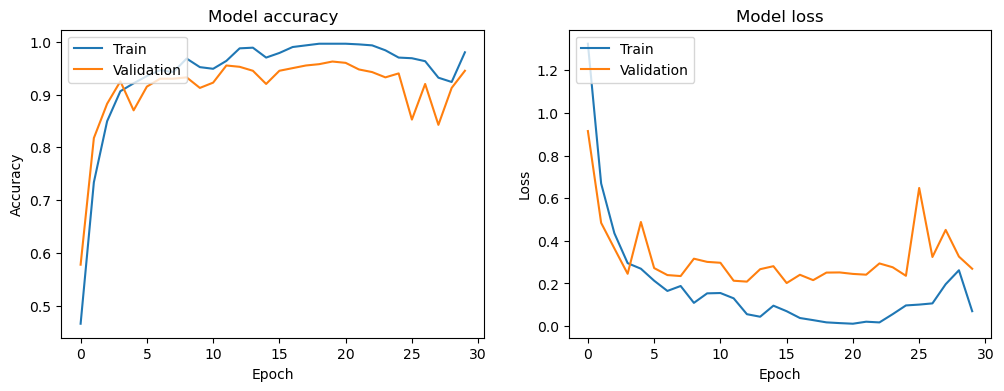

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [10]:

# Prediction and Misclassification Analysis Function

from sklearn.metrics import confusion_matrix
from collections import defaultdict

# Load your trained model
#model = load_model('spoken_language_model_bhai3649.h5')

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through each file and predict its label
for audio_file in audio_files:
    file_path = audio_file['file_path']
    true_label = audio_file['label']
    
    # Extract features from the audio file
    features =combined_features_extractor(file_path)
    
    # Reshape features to match model input shape
    features = np.expand_dims(features, axis=0)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction, axis=1)
    
    # Convert the predicted class index to the class label
    predicted_label = label_encoder.inverse_transform(predicted_class)[0]
    
    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)
    
    # Print for each file (optional)
    print(f'File: {file_path}, True Label: {true_label}, Predicted Label: {predicted_label}')

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)

# Print confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

# Misclassification analysis
misclassifications = defaultdict(lambda: defaultdict(int))

for true_label, pred_label in zip(true_labels, predicted_labels):
    if true_label != pred_label:
        misclassifications[true_label][pred_label] += 1

# Calculate and print misclassification percentages
print("\nMisclassification Percentages:")
for true_label in label_encoder.classes_:
    total_samples = np.sum(true_labels == true_label)
    if total_samples > 0:
        print(f'For true label "{true_label}":')
        correct_predictions = np.sum((true_labels == true_label) & (predicted_labels == true_label))
        correct_percentage = (correct_predictions / total_samples) * 100
        print(f'  Correctly classified as {true_label}: {correct_percentage:.2f}%')
        
        for misclassified_label, count in misclassifications[true_label].items():
            misclass_percentage = (count / total_samples) * 100
            print(f'  Misclassified as {misclassified_label}: {misclass_percentage:.2f}%')


1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913722.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913723.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913724.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913725.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 23ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14

1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913898.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913900.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913901.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28913902.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14

1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914077.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 40ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914079.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914080.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 40ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914081.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14

1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914243.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914245.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914246.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914247.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14

1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914390.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914392.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914394.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914395.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14

1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914628.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914630.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914634.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914635.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14

1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914813.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914817.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914818.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\ml_3650\common_voice_ml_28914819.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14

1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23828714.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23828715.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 21ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23828716.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 22ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23828722.mp3, True Label: Hindi, Predicted Label: Urdu
1/1 [==============================] - 0s 23ms/step
File: C:\Users\anasa\Downloads\da

1/1 [==============================] - 0s 23ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23830521.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 22ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23830522.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 23ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23830523.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 23ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23830524.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23832741.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23832954.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 22ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23832955.mp3, True Label: Hindi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23832956.mp3, True Label: Hindi, Predicted Label: Marathi
1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloa

1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23834324.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23834325.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23834326.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23834327.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23844539.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 45ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23844540.mp3, True Label: Hindi, Predicted Label: Korean
1/1 [==============================] - 0s 43ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23844541.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 43ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23844542.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\

1/1 [==============================] - 0s 37ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23849311.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23849312.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23849313.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 37ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23849314.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852754.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852755.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852756.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852757.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852815.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852883.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852884.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 31ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23852885.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23937561.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23937562.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23937563.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 35ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23937564.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 59ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23964497.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23964498.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 58ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23964499.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 54ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23964500.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 65ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23976076.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 49ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23976077.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23976078.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_23997794.mp3, True Label: Hindi, Predicted Label: Urdu
1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\da

1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026241.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026242.mp3, True Label: Hindi, Predicted Label: Korean
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026243.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026244.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\

1/1 [==============================] - 0s 37ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026317.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026318.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026319.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026330.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 31ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026446.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 31ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026447.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026463.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\hi_3650\common_voice_hi_24026464.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 31ms/step
File: C:\Users\anasa\Downloads\d

1/1 [==============================] - 0s 43ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35846214.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35846215.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35846216.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35846247.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 55ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35846248

1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35848037.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35848083.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 33ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35848084.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35848085.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35848086

1/1 [==============================] - 0s 37ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35850708.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35850710.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35850711.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 52ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35850745.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 49ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35850746

1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35890697.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 31ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35890698.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35890699.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35890700.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 35ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35890701

1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35891314.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35891315.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35891349.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35891351.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35891355

1/1 [==============================] - 0s 73ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35905260.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 65ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35905261.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 57ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35905263.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 70ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35905264.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 71ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35905298

1/1 [==============================] - 0s 45ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35922875.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 42ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35922879.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 42ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35922881.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35922882.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 50ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\clips\common_voice_ko_35922883

1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27564985.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27564986.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27564992.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 32ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27564993.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 34ms/step
File: C:\Users\a

1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27565190.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 40ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27565191.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27565212.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27565213.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\a

1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27582671.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27582672.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27582682.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27582684.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 24ms/step
File: C:\Users\a

1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27591989.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27591990.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27591997.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27591998.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 30ms/step
File: C:\Users\a

File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27650992.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27650995.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27651210.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27651211.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\

1/1 [==============================] - 0s 29ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27652926.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27652927.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27652928.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27652929.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 25ms/step
File: C:\Users\a

1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27672644.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 43ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27672646.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 43ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27672647.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27672648.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 49ms/step
File: C:\Users\a

1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27703237.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27703240.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27703241.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\mr_3650\common_voice_mr_27703242.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 26ms/step
File: C:\Users\a

1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31981946.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31981947.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31981948.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 23ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31981949.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\c

1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982023.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 28ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982024.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982025.mp3, True Label: Urdu, Predicted Label: Korean
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982026.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset

1/1 [==============================] - 0s 40ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982105.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982106.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 36ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982107.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 39ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982108.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\dataset\c

1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982202.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 20ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982203.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 26ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982204.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 27ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982205.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\c

1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982284.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 22ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982285.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982286.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 22ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982287.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\c

1/1 [==============================] - 0s 38ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982361.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982362.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982363.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 38ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982364.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 34ms/step
File: C:\Users\anasa\Downloads\dataset\c

1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982458.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982459.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 24ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982460.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_3650\common_voice_ur_31982461.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 25ms/step
File: C:\Users\anasa\Downloads\dataset\c

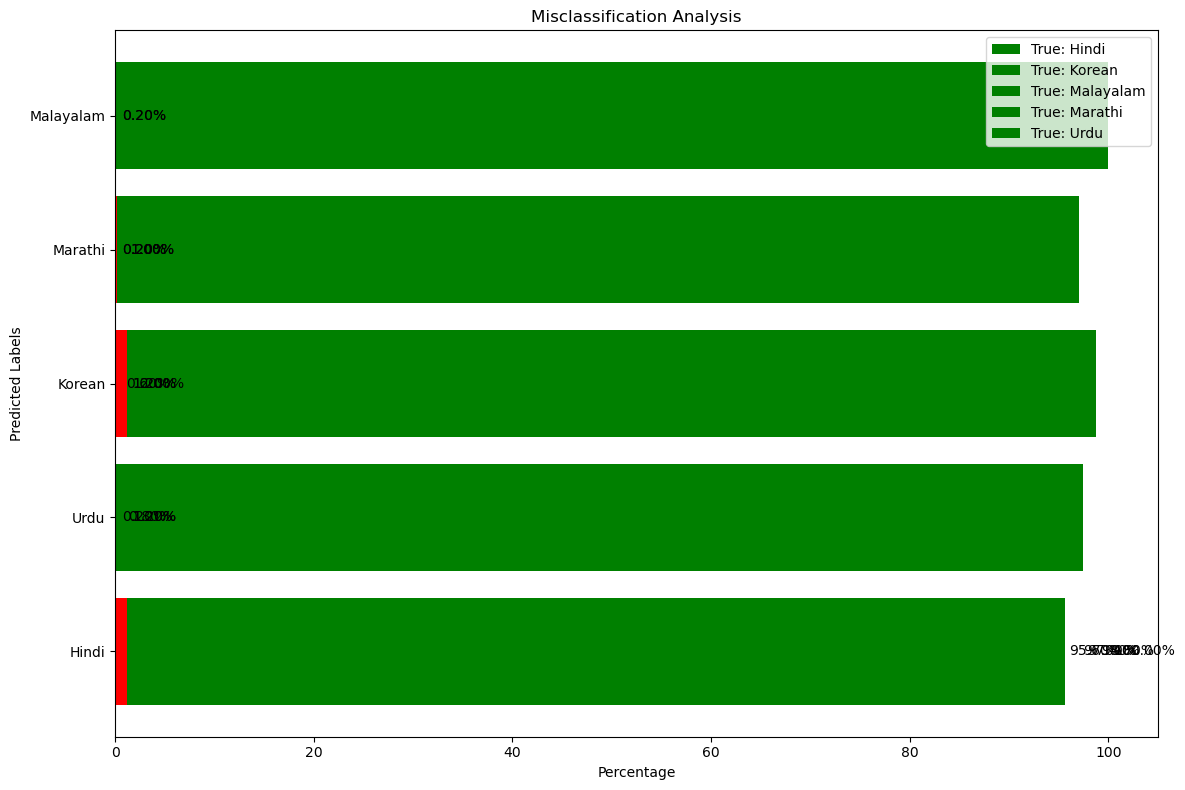

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate misclassification percentages and store them in a dictionary
misclassification_percentages = {}

for true_label in label_encoder.classes_:
    total_samples = np.sum(true_labels == true_label)
    if total_samples > 0:
        misclassification_percentages[true_label] = {}
        correct_predictions = np.sum((true_labels == true_label) & (predicted_labels == true_label))
        correct_percentage = (correct_predictions / total_samples) * 100

        # Store correct classification percentage
        misclassification_percentages[true_label][true_label] = correct_percentage

        for misclassified_label, count in misclassifications[true_label].items():
            misclass_percentage = (count / total_samples) * 100
            misclassification_percentages[true_label][misclassified_label] = misclass_percentage

# Plot the misclassification results
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for correct classifications and misclassifications
correct_color = 'green'
misclass_color = 'red'

for true_label, misclass_dict in misclassification_percentages.items():
    labels = list(misclass_dict.keys())
    percentages = list(misclass_dict.values())
    
    # Define bar colors (green for correct, red for misclassified)
    colors = [correct_color if label == true_label else misclass_color for label in labels]
    
    # Create a bar plot for each true label
    ax.barh(labels, percentages, color=colors, label=f'True: {true_label}')
    
    # Annotate each bar with the percentage
    for i, v in enumerate(percentages):
        ax.text(v + 0.5, i, f"{v:.2f}%", color='black', va='center')

# Set plot labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Predicted Labels')
ax.set_title('Misclassification Analysis')
ax.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()


In [12]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from collections import defaultdict



# Define the list of directories and their corresponding labels
directories_and_labels = [
    (r"C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100", 'Malayalam'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\test_hi_100', 'Hindi'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100', 'Korean'),
    (r"C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100", 'Marathi'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100','Nepali'),
    (r'C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100','Urdu'),
]

# List to store file paths and labels
audio_files = []

# Loop over each directory and label
for directory, class_label in directories_and_labels:
    print(f"Processing directory: {directory} with label: {class_label}")

    # Walk through the directory and gather all file paths
    for root, dirs, files in tqdm(os.walk(directory)):
        for file in files:
            if file.endswith('.mp3'):  # Add other audio file extensions if needed
                file_path = os.path.join(root, file)
                audio_files.append({"file_path": file_path, "label": class_label})

# Check the number of files collected
print(f"Total files collected: {len(audio_files)}")

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through each file and predict its label
for audio_file in audio_files:
    file_path = audio_file['file_path']
    true_label = audio_file['label']
    
    # Extract features from the audio file
    features =combined_features_extractor(file_path)
    
    # Reshape features to match model input shape
    features = np.expand_dims(features, axis=0)  # Add batch dimension
    
    # Predict the class
    prediction = model.predict(features)
    predicted_class = np.argmax(prediction, axis=1)
    
    # Convert the predicted class index to the class label
    predicted_label = label_encoder.inverse_transform(predicted_class)[0]
    
    # Store true and predicted labels
    true_labels.append(true_label)
    predicted_labels.append(predicted_label)
    
    # Print for each file (optional)
    print(f'File: {file_path}, True Label: {true_label}, Predicted Label: {predicted_label}')

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=label_encoder.classes_)

# Print confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

# Misclassification analysis
misclassifications = defaultdict(lambda: defaultdict(int))

for true_label, pred_label in zip(true_labels, predicted_labels):
    if true_label != pred_label:
        misclassifications[true_label][pred_label] += 1

# Calculate and print misclassification percentages
print("\nMisclassification Percentages:")
for true_label in label_encoder.classes_:
    total_samples = np.sum(true_labels == true_label)
    if total_samples > 0:
        print(f'For true label "{true_label}":')
        correct_predictions = np.sum((true_labels == true_label) & (predicted_labels == true_label))
        correct_percentage = (correct_predictions / total_samples) * 100
        print(f'  Correctly classified as {true_label}: {correct_percentage:.2f}%')
        
        for misclassified_label, count in misclassifications[true_label].items():
            misclass_percentage = (count / total_samples) * 100
            print(f'  Misclassified as {misclassified_label}: {misclass_percentage:.2f}%')


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100 with label: Malayalam


1it [00:00, 176.22it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\test_hi_100 with label: Hindi


1it [00:00, 177.71it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100 with label: Korean


1it [00:00, 186.15it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100 with label: Marathi


1it [00:00, 179.70it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100 with label: Nepali


1it [00:00, 230.86it/s]


Processing directory: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100 with label: Urdu


1it [00:00, 142.42it/s]

Total files collected: 600


1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913599.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 50ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913600.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 54ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913601.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913602.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus

1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913647.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 45ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913648.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 50ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913649.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913650.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus

1/1 [==============================] - 0s 49ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913684.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913685.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 51ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913686.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ml\malayalam\ml\test_ml_100\common_voice_ml_28913687.mp3, True Label: Malayalam, Predicted Label: Malayalam
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus

1/1 [==============================] - 0s 50ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\test_hi_100\common_voice_hi_23809713.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 51ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\test_hi_100\common_voice_hi_23809719.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\test_hi_100\common_voice_hi_23809720.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 66ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-hi\cv-corpus-18.0-2024-06-14\hi\test_hi_100\common_voice_hi_23809721.mp3, True Label: Hindi, Predicted Label: Hindi
1/1 [==============================] - 0s 49ms/step
File: C:\Users\a

1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35844229.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35844230.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 45ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35844231.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35844289.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_k

1/1 [==============================] - 0s 51ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845416.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 51ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845417.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845419.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845420.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_k

1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845934.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845935.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 49ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845955.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_ko_100\common_voice_ko_35845957.mp3, True Label: Korean, Predicted Label: Korean
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ko\korean\ko\test_k

1/1 [==============================] - 0s 52ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100\common_voice_mr_27554970.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 49ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100\common_voice_mr_27554971.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 53ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100\common_voice_mr_27554972.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100\common_voice_mr_27554973.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 49ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100\common_voice_mr_27555005.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 54ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-mr\cv-corpus-18.0-2024-06-14\mr\test_mr_100\common_voice_mr_27555006.mp3, True Label: Marathi, Predicted Label: Marathi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32417292.mp3, True Label: Nepali, Predicted Label: Korean
1/1 [==============================] - 0s 49ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32417293.mp3, True Label: Nepali, Predicted Label: Korean
1/1 [==============================] -

1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32521125.mp3, True Label: Nepali, Predicted Label: Hindi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32521127.mp3, True Label: Nepali, Predicted Label: Hindi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32521130.mp3, True Label: Nepali, Predicted Label: Hindi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32521131.mp3, True Label: Nepali, Predicted Label: Hindi
1/1 [=======================

1/1 [==============================] - 0s 45ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32826941.mp3, True Label: Nepali, Predicted Label: Hindi
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32826942.mp3, True Label: Nepali, Predicted Label: Marathi
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32826943.mp3, True Label: Nepali, Predicted Label: Korean
1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ne-NP\cv-corpus-18.0-2024-06-14\ne-NP\test_NP_100\common_voice_ne-NP_32826944.mp3, True Label: Nepali, Predicted Label: Korean
1/1 [===================

1/1 [==============================] - 0s 47ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986374.mp3, True Label: Urdu, Predicted Label: Hindi
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986376.mp3, True Label: Urdu, Predicted Label: Hindi
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986378.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 41ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986379.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 42ms/step
File: C:\Users\anasa\Downloads\dataset\cv-

1/1 [==============================] - 0s 45ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986471.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 44ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986472.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 46ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986473.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 42ms/step
File: C:\Users\anasa\Downloads\dataset\cv-corpus-18.0-2024-06-14-ur\cv-corpus-18.0-2024-06-14\ur\ur_100\common_voice_ur_31986474.mp3, True Label: Urdu, Predicted Label: Urdu
1/1 [==============================] - 0s 48ms/step
File: C:\Users\anasa\Downloads\dataset\cv-co

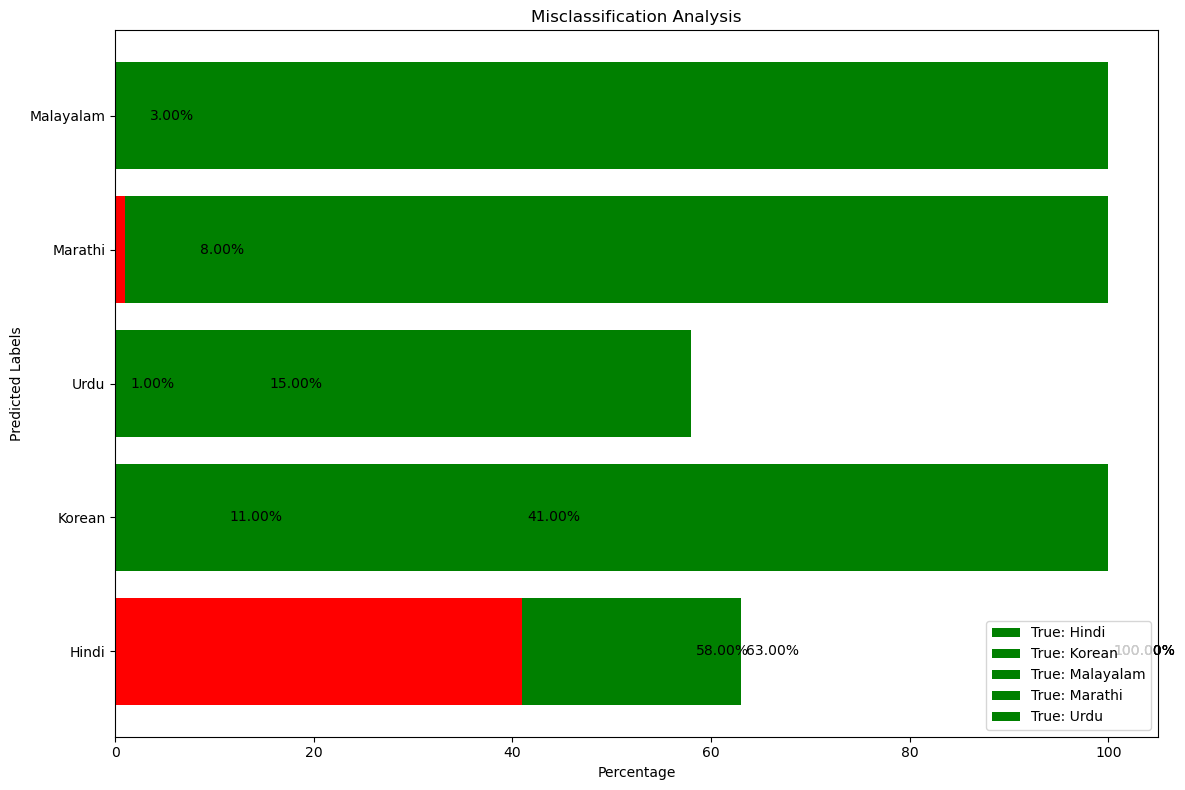

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate misclassification percentages and store them in a dictionary
misclassification_percentages = {}

for true_label in label_encoder.classes_:
    total_samples = np.sum(true_labels == true_label)
    if total_samples > 0:
        misclassification_percentages[true_label] = {}
        correct_predictions = np.sum((true_labels == true_label) & (predicted_labels == true_label))
        correct_percentage = (correct_predictions / total_samples) * 100

        # Store correct classification percentage
        misclassification_percentages[true_label][true_label] = correct_percentage

        for misclassified_label, count in misclassifications[true_label].items():
            misclass_percentage = (count / total_samples) * 100
            misclassification_percentages[true_label][misclassified_label] = misclass_percentage

# Plot the misclassification results
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for correct classifications and misclassifications
correct_color = 'green'
misclass_color = 'red'

for true_label, misclass_dict in misclassification_percentages.items():
    labels = list(misclass_dict.keys())
    percentages = list(misclass_dict.values())
    
    # Define bar colors (green for correct, red for misclassified)
    colors = [correct_color if label == true_label else misclass_color for label in labels]
    
    # Create a bar plot for each true label
    ax.barh(labels, percentages, color=colors, label=f'True: {true_label}')
    
    # Annotate each bar with the percentage
    for i, v in enumerate(percentages):
        ax.text(v + 0.5, i, f"{v:.2f}%", color='black', va='center')

# Set plot labels and title
ax.set_xlabel('Percentage')
ax.set_ylabel('Predicted Labels')
ax.set_title('Misclassification Analysis')
ax.legend(loc='best')

# Show the plot
plt.tight_layout()
plt.show()
